### Проектная работа по разделу "Анализ бизнес показателей" : Аналитика в Яндекс.Афише

**Описание:** изучение данных от Яндекс.Афиши с июня 2017 по конец мая 2018 года на основании лога сервера с данными о посещениях сайта Яндекс.Афиши, выгрузки всех заказов за этот период и статистики рекламных расходов.

**Цель:** помочь маркетологам Яндекс.Афиши более эффективно инвестировать деньги в маркетинг, основываясь на том:
- как пользователи пользуются продуктом,
- когда они начинают покупать,
- сколько денег приносит каждый клиент
- когда клиент окупается.

### Содержание:
<a href = '#Sect1'>  <b> Шаг 1: Загрузка данных и подготовка их к анализу </b> </a></p>
<a href = '#Sect2'>  <b> Шаг 2: Построение отчётов и расчет метрик </b> </a></p>
<p style='margin-left: 40px'><a href = '#Sect2.1'>  <b> Шаг 2.1: Продукт</b></a></p>
<p style='margin-left: 40px'><a href = '#Sect2.2'>  <b> Шаг 2.2: Продажи</b></a></p>
<p style='margin-left: 40px'><a href = '#Sect2.3'>  <b> Шаг 2.3: Маркетинг</b></a></p>
<p><a href = '#Sect3'>  <b> Шаг 3: Вывод</b></a></p> 


### <a id = 'Sect1'></a> Шаг 1. Загрузка данных и подготовка их к анализу

Загрузим данные о визитах, заказах и расходах в переменные

In [1]:
import pandas as pd
from IPython.display import display 
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

#импорт данных
visits = pd.read_csv('/datasets/visits_log.csv')
orders = pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')


In [2]:
display(visits.head())
visits.info()
display(orders.head())
orders.info()
display(costs.head())
costs.info()

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


Пропусков в данных нет, но тип данных в колонках с датами необходимо перевести в datetime для работы. Оптимизируем данные для анализа. Переименуем колонки для удобства и переведем даты в нужный тип

In [3]:
# переименование колонок в нижний регистр и замена пробелов на нижнее подчеркивание
visits.columns = ['device', 'end_ts', 'source_id', 'start_ts', 'user_id']
orders.columns = ['buy_ts', 'revenue', 'user_id']
costs.columns = ['source_id', 'date', 'costs']

# перевод колонок с датами в соответсвующий тип данных
visits['end_ts'] = pd.to_datetime(visits['end_ts'])
visits['start_ts'] = pd.to_datetime(visits['start_ts'])
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])
costs['date'] =  pd.to_datetime(costs['date'])

### <a id = 'Sect2'></a> Шаг 2. Построение отчётов и расчет метрик

#### <a id = 'Sect2.1'></a> Шаг 2.1 Продукт

Проведем анализ данных о пользовательский сессиях, определим:

- Сколько клиентов пользуются в день, неделю, месяц?
- Сколько сессий в день?
- Сколько длится одна сессия?
- Как часто люди возвращаются?


In [4]:
# добавляем колонки с датой, месяцем и неделей пользовательской сессии
visits['sess_day'] = visits['end_ts'].dt.date
visits['sess_month'] = visits['end_ts'].astype('datetime64[M]')
visits['sess_week'] = visits['end_ts'].dt.week
visits['sess_year'] = visits['end_ts'].dt.year

display(visits.head())
# количество сессий за день
visits_per_day_d = visits.query('device == "desktop"').groupby('sess_day')['end_ts'].count()
visits_per_day_d = visits.query('device == "desktop"').groupby('sess_day')['end_ts'].count()
visits_per_day_t = visits.query('device == "touch"').groupby('sess_day')['end_ts'].count()
# количество сессий за месяц
visits_per_month = visits.groupby('sess_month')['end_ts'].count()
visits_per_month_d = visits.query('device == "desktop"').groupby('sess_month')['end_ts'].count()
visits_per_month_t = visits.query('device == "touch"').groupby('sess_month')['end_ts'].count()

# количество сессий за неделю
visits_per_week = visits.groupby(['sess_year', 'sess_week'])['end_ts'].count()
visits_per_week_d = visits.query('device == "desktop"').groupby(['sess_year', 'sess_week'])['end_ts'].count()
visits_per_week_t = visits.query('device == "touch"').groupby(['sess_year', 'sess_week'])['end_ts'].count()


# медиана сессий за день 
print('медиана визитов за день (desktop):',visits.query('device == "desktop"').groupby('sess_day')['end_ts'].count().median())
print('медиана визитов за день (touch) :',visits.query('device == "touch"').groupby('sess_day')['end_ts'].count().median())

# медиана сессий за неделю 
print('медиана визитов за неделю (desktop):',visits.query('device == "desktop"').groupby(['sess_year','sess_week'])['end_ts'].count().median())
print('медиана визитов за неделю (touch):',visits.query('device == "touch"').groupby(['sess_year','sess_week'])['end_ts'].count().median())
# медиана сессий за месяц
print('медиана визитов за месяц (desktop):',visits.query('device == "desktop"').groupby('sess_month')['end_ts'].count().median())
print('медиана визитов за месяц (touch):',visits.query('device == "touch"').groupby('sess_month')['end_ts'].count().median())

,device,end_ts,source_id,start_ts,user_id,sess_day,sess_month,sess_week,sess_year
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017-12-01,51,2017
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018-02-01,8,2018
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-07-01,26,2017
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,2018-05-01,20,2018
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,2017-12-01,52,2017


медиана визитов за день (desktop): 709.0
медиана визитов за день (touch) : 278.0
медиана визитов за неделю (desktop): 4892.0
медиана визитов за неделю (touch): 1874.0
медиана визитов за месяц (desktop): 19226.0
медиана визитов за месяц (touch): 7749.0


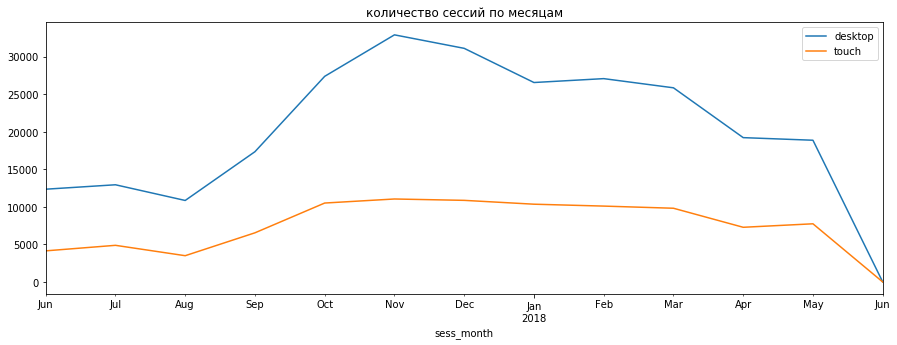

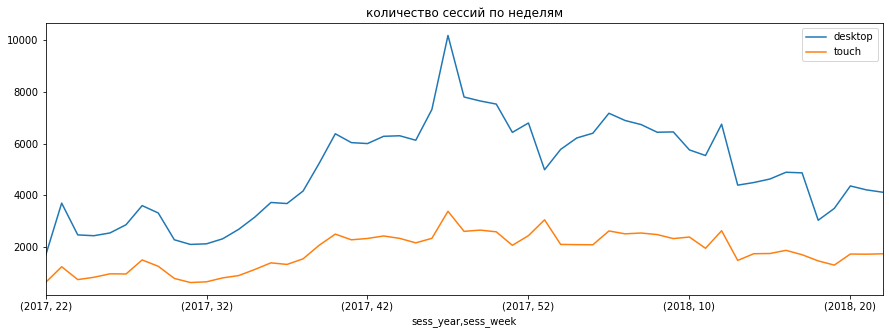

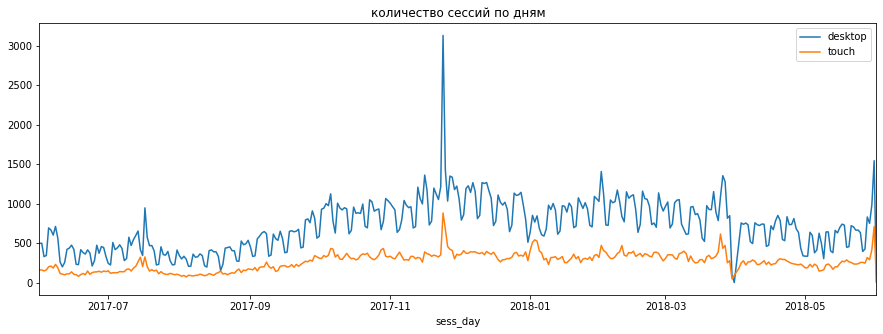

In [5]:
# визуализация кол-ва сессий по месяцам
visits_per_month_d.plot(figsize=(15,5))
visits_per_month_t.plot(figsize=(15,5))
plt.title('количество сессий по месяцам')
plt.legend(['desktop', 'touch'])
plt.show()

# визуализация кол-ва сессий по неделям
visits_per_week_d.plot(figsize=(15,5))
visits_per_week_t.plot(figsize=(15,5))
plt.legend(['desktop', 'touch'])
plt.title('количество сессий по неделям')
plt.show()

# визуализация кол-ва сессий по дням
visits_per_day_d.plot(figsize=(15,5))
visits_per_day_t.plot(figsize=(15,5))
plt.legend(['desktop', 'touch'])
plt.title('количество сессий по дням')
plt.show()


**Вывод:** в летние месяцы число пользователей сокращается, люди предпочитают организовывать свой досуг на воздухе или уезжают, также это может быть связано с тем, что в театрах заканчивается сезон и летом проводится меньше спектаклей, постановок, показов. Осенью активность возрастает, пик приходится на ноябрь 2017.

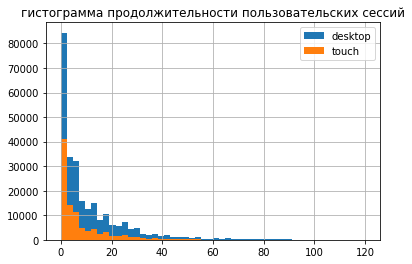

'медиана продолжительности сессии (desktop)'

5.0

'медиана продолжительности сессии (touch)'

5.0

'наиболее часто встречающаяся продолжительность сессии (desktop)'

0    1
dtype: int64

'наиболее часто встречающаяся продолжительность сессии (touch)'

0    1
dtype: int64

статистика продолжительности сессий (desktop): count    262567.000000
mean         11.731661
std          18.192928
min           0.000000
25%           2.000000
50%           6.000000
75%          15.000000
max        1408.000000
Name: sess_duration_min, dtype: float64
статистика продолжительности сессий (touch): count    96833.000000
mean         7.992957
std         12.542629
min          0.000000
25%          1.000000
50%          3.000000
75%         10.000000
max        514.000000
Name: sess_duration_min, dtype: float64


In [6]:
# определим продолжительность пользовательской сессии как разность между временем окончания и начала
visits['sess_duration'] = (visits['end_ts'] - visits['start_ts'])

# построим гистограмму продолжительности сессии в минутах
time = pd.DatetimeIndex(visits['sess_duration'])
plt.show()
visits['sess_duration_min'] = time.hour * 60 + time.minute
visits.query('device == "desktop"')['sess_duration_min'].hist(bins = 50, range=[0, 120])
visits.query('device == "touch"')['sess_duration_min'].hist(bins = 50, range=[0, 120])
plt.legend(['desktop', 'touch'])
plt.title('гистограмма продолжительности пользовательских сессий')
plt.show()


display('медиана продолжительности сессии (desktop)',visits['sess_duration_min'].median())
display('медиана продолжительности сессии (touch)',visits['sess_duration_min'].median())
display('наиболее часто встречающаяся продолжительность сессии (desktop)',visits.query('device == "desktop"')['sess_duration_min'].mode())
display('наиболее часто встречающаяся продолжительность сессии (touch)',visits.query('device == "touch"')['sess_duration_min'].mode())
# выведем статистику продолжительности сессий
print('статистика продолжительности сессий (desktop):', visits.query('device == "desktop"')['sess_duration_min'].describe())

print('статистика продолжительности сессий (touch):',visits.query('device == "touch"')['sess_duration_min'].describe())


**Вывод:** наиболее часто встречающаяся продолжительность сессии: 1 минута, среднее время 15 минут, а медиана 9 минут, видимо в большом количестве случаев пользователи заходят на сайт посмотреть нет ли интересных событий, которые они хотели бы посетить в ближайшее время. минимальное время сессии составляет 0 минут, что говорит либо о том, что страница могла не отобразиться, либо пользователь закрыл страницу. Найдем количество сессий с нулевой продолжительностью

In [7]:
sess_total = visits['sess_duration_min'].count()
print('всего сессиий: ',sess_total)
sess_duration_0 = visits.query('sess_duration_min == 0')['sess_duration_min'].count()
print("сессий с нулевой продолжительностью : ",sess_duration_0, '({:.1%})'.format(sess_duration_0/sess_total) )

всего сессиий:  359400
сессий с нулевой продолжительностью :  36662 (10.2%)


посчитаем сколько сессиий, уникальных пользователей и сессий на каждого юзера приходилось по месяцам

In [8]:
# количество сессий и количество уникальных пользователей по месяцам
sessions_per_user =  visits.groupby('sess_month').agg({'user_id': ['count','nunique']})
sessions_per_user.columns = ['n_sessions', 'n_users']
sessions_per_user['sessions_per_user'] = sessions_per_user['n_sessions'] / sessions_per_user['n_users']
display(sessions_per_user)                          

,n_sessions,n_users,sessions_per_user
sess_month,,,
2017-06-01,16501,13255,1.244889
2017-07-01,17828,14183,1.256998
2017-08-01,14355,11631,1.234202
2017-09-01,23900,18968,1.260017
2017-10-01,37905,29692,1.276606
2017-11-01,43970,32798,1.340631
2017-12-01,41990,31560,1.330482
2018-01-01,36926,28707,1.286306
2018-02-01,37192,28755,1.293410


визуализируем показатели полученные в таблице выше

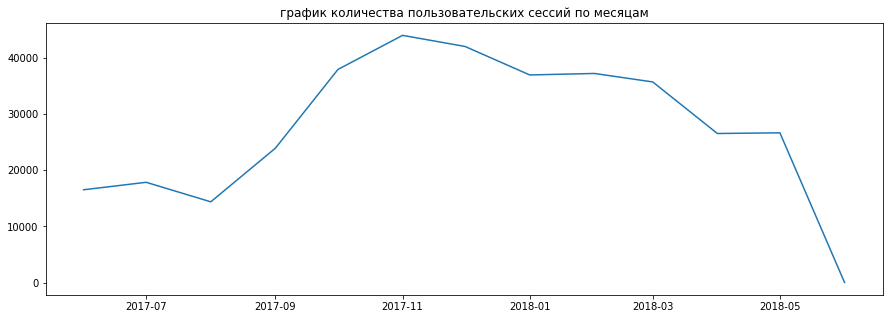

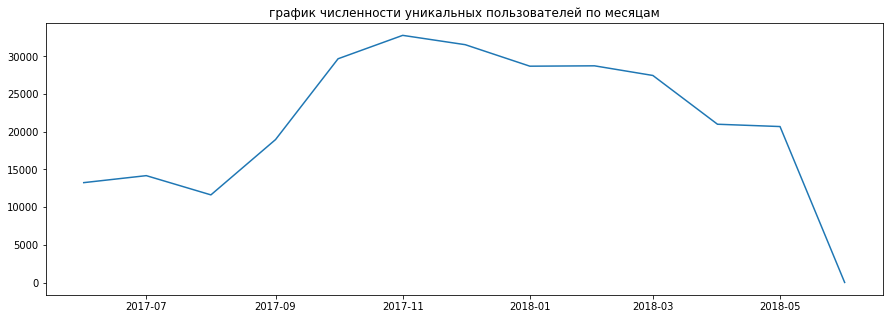

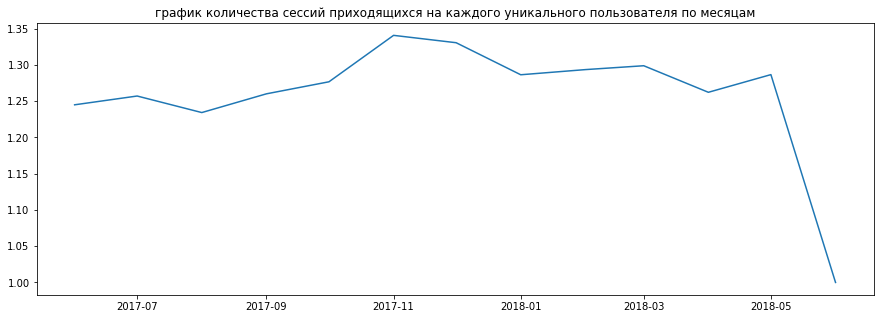

In [9]:
plt.figure(figsize=(15,5))
plt.title('график количества пользовательских сессий по месяцам')
plt.plot(sessions_per_user.index,sessions_per_user['n_sessions'])
plt.show()

plt.figure(figsize=(15,5))
plt.title('график численности уникальных пользователей по месяцам')
plt.plot(sessions_per_user.index,sessions_per_user['n_users'])
plt.show()

plt.figure(figsize=(15,5))
plt.title('график количества сессий приходящихся на каждого уникального пользователя по месяцам')
plt.plot(sessions_per_user.index,sessions_per_user['sessions_per_user'])
plt.show()

Посчитаем метрики об новых пользователях. Сгруппируем данные по уникальным пользователям и найдём среднее:

In [10]:
# среднее количество уникальных пользователей в месяц, MAU
mau_total =  visits.groupby('sess_month').agg({'user_id': 'nunique'}).mean()
print('среднее количество уникальных пользователей в месяц, MAU : ', mau_total)

# среднее количество уникальных пользователей в наделю, WAU
wau_total = visits.groupby('sess_week').agg({'user_id': 'nunique'}).mean()
print('среднее количество уникальных пользователей в неделю, WAU : ', wau_total)

# среднее количество уникальных пользователей в день, DAU
dau_total = visits.groupby('sess_day').agg({'user_id': 'nunique'}).mean()
print('среднее количество уникальных пользователей в день, DAU : ', dau_total)

среднее количество уникальных пользователей в месяц, MAU :  user_id    21441.384615
dtype: float64
среднее количество уникальных пользователей в неделю, WAU :  user_id    5825.038462
dtype: float64
среднее количество уникальных пользователей в день, DAU :  user_id    905.539726
dtype: float64


визуализируем изменение этих показателей в течение периода

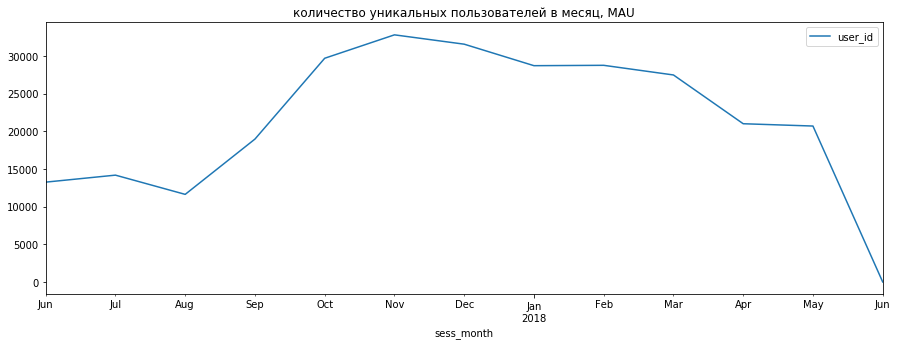

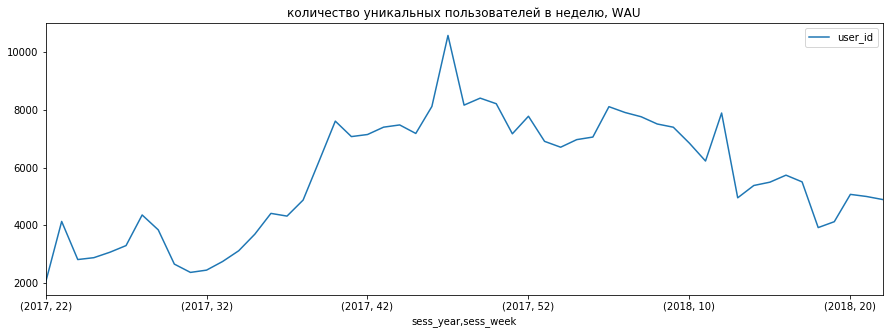

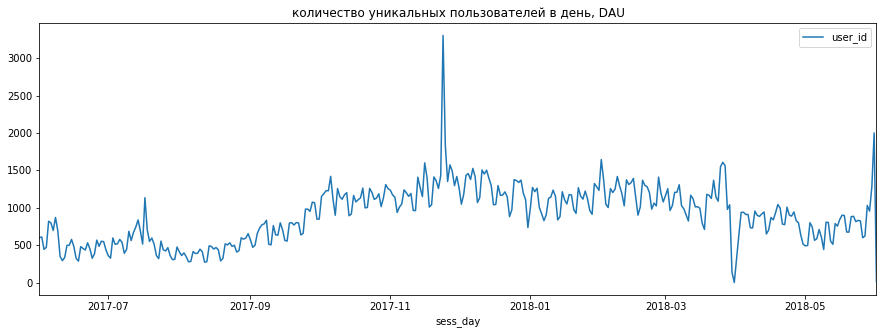

In [11]:
# график изменения количества уникальных пользователей в месяц, MAU
visits.groupby('sess_month').agg({'user_id': 'nunique'}).plot(figsize=(15,5))
plt.title('количество уникальных пользователей в месяц, MAU')
plt.show()

# график изменения количества уникальных пользователей в неделю, WAU
visits.groupby(['sess_year','sess_week']).agg({'user_id': 'nunique'}).plot(figsize=(15,5))
plt.title('количество уникальных пользователей в неделю, WAU')
plt.show()

# график изменения количества уникальных пользователей в день, DAU
visits.groupby('sess_day').agg({'user_id': 'nunique'}).plot(figsize=(15,5))
plt.title('количество уникальных пользователей в день, DAU')
plt.show()

In [12]:
sticky_wau = dau_total / wau_total * 100
sticky_mau = dau_total / mau_total * 100
print(sticky_wau)
print(sticky_mau)

user_id    15.545644
dtype: float64
user_id    4.223327
dtype: float64


найдем коэффициент удержания (Retention Rate), чтобы выяснить сколько пользователей из когорты относительно их изначального числа вернулось в последующие периоды.

In [13]:
# находим первые сессии пользователей
first_visit_date_by_user = visits.groupby('user_id')['sess_day'].min()
first_visit_date_by_user.name = 'first_visit_date'

# добавляем в общую таблицу с посещениями
visits = visits.join(first_visit_date_by_user, on = 'user_id')
visits['first_visit_month'] = visits['first_visit_date'].astype('datetime64[M]')

In [14]:
visits['sess_month'] = visits['sess_month'].astype('datetime64[M]')
visits['v_cohort_lifetime'] = visits['sess_month'] - visits['first_visit_month']
visits['v_cohort_lifetime'] = visits['v_cohort_lifetime'] / np.timedelta64(1,'M')
visits['v_cohort_lifetime'] = visits['v_cohort_lifetime'].round(0)
visits['v_cohort_lifetime'] = visits['v_cohort_lifetime'].astype('int')

In [15]:
display(visits['v_cohort_lifetime'])

0         0
1         0
2         0
3         2
4         0
         ..
359395    0
359396    0
359397    0
359398    0
359399    0
Name: v_cohort_lifetime, Length: 359400, dtype: int64

In [16]:
display(visits.head())
visits.info()

,device,end_ts,source_id,start_ts,user_id,sess_day,sess_month,sess_week,sess_year,sess_duration,sess_duration_min,first_visit_date,first_visit_month,v_cohort_lifetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017-12-01,51,2017,00:18:00,18,2017-12-20,2017-12-01,0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018-02-01,8,2018,00:28:00,28,2018-02-19,2018-02-01,0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-07-01,26,2017,00:00:00,0,2017-07-01,2017-07-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,2018-05-01,20,2018,00:24:00,24,2018-03-09,2018-03-01,2
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,2017-12-01,52,2017,00:00:00,0,2017-12-27,2017-12-01,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 14 columns):
device               359400 non-null object
end_ts               359400 non-null datetime64[ns]
source_id            359400 non-null int64
start_ts             359400 non-null datetime64[ns]
user_id              359400 non-null uint64
sess_day             359400 non-null object
sess_month           359400 non-null datetime64[ns]
sess_week            359400 non-null int64
sess_year            359400 non-null int64
sess_duration        359400 non-null timedelta64[ns]
sess_duration_min    359400 non-null int64
first_visit_date     359400 non-null object
first_visit_month    359400 non-null datetime64[ns]
v_cohort_lifetime    359400 non-null int64
dtypes: datetime64[ns](4), int64(5), object(3), timedelta64[ns](1), uint64(1)
memory usage: 38.4+ MB


Сгруппируем данные по когорте и lifetime. Посчитаем для каждой когорты количество активных пользователей на определённый «месяц жизни»:

In [17]:
cohorts = visits.groupby(['first_visit_month','v_cohort_lifetime']).agg({'user_id':'nunique'}).reset_index() 

Найдём исходное количество пользователей в когорте. Возьмём их число на нулевой месяц:

In [18]:
initial_users_count = cohorts[cohorts['v_cohort_lifetime'] == 0][['first_visit_month','user_id']]
print(initial_users_count)

   first_visit_month  user_id
0         2017-06-01    13255
12        2017-07-01    13140
23        2017-08-01    10181
33        2017-09-01    16700
42        2017-10-01    25979
50        2017-11-01    27252
57        2017-12-01    25269
63        2018-01-01    22615
68        2018-02-01    22204
72        2018-03-01    20592
75        2018-04-01    15706
77        2018-05-01    15269
79        2018-06-01        7


Переименуем столбец **user_id** в **cohort_users**

In [19]:
initial_users_count = initial_users_count.rename(columns={'user_id':'cohort_users'}) 

Объединим данные по когортам с исходным количеством пользователей в когорте:

In [20]:
cohorts = cohorts.merge(initial_users_count,on='first_visit_month') 


Рассчитаем Retention Rate. Разделим количество активных пользователей в каждую из недель на исходное число пользователей в когорте:

In [21]:
cohorts['retention'] = cohorts['user_id']/cohorts['cohort_users'] 
#cohorts['first_visit_month'] = cohorts['first_visit_month'].astype('datetime64[M]')

Построим сводную таблицу и создадим тепловую карту:

In [22]:
retention_pivot = cohorts.pivot_table(index='first_visit_month',columns='v_cohort_lifetime',values='retention',aggfunc='sum') 

In [23]:
#среднее по продолжительности жизни среди всех когорт к данной сводной таблице
retention_pivot.loc['mean'] = retention_pivot.mean()

In [24]:
display(cohorts)

,first_visit_month,v_cohort_lifetime,user_id,cohort_users,retention
0,2017-06-01,0,13255,13255,1.000000
1,2017-06-01,1,1043,13255,0.078687
2,2017-06-01,2,713,13255,0.053791
3,2017-06-01,3,814,13255,0.061411
4,2017-06-01,4,909,13255,0.068578
...,...,...,...,...,...
75,2018-04-01,0,15706,15706,1.000000
76,2018-04-01,1,760,15706,0.048389
77,2018-05-01,0,15269,15269,1.000000
78,2018-05-01,1,5,15269,0.000327


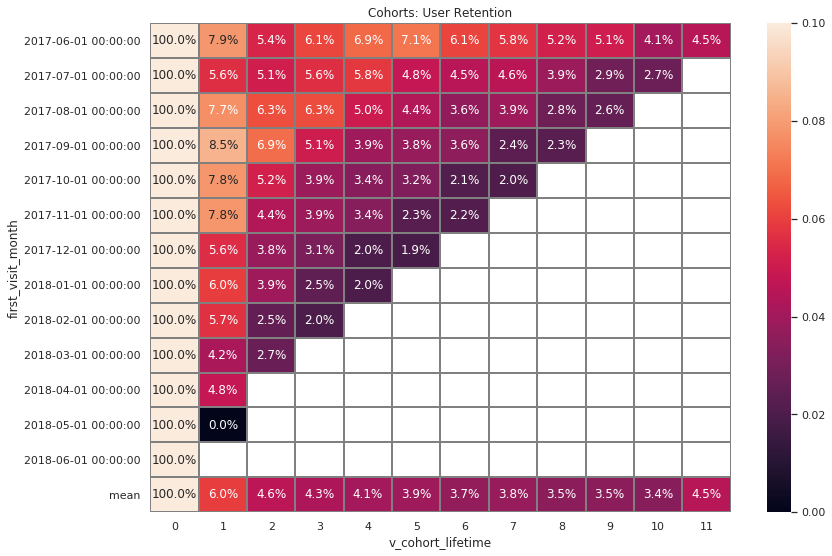

In [25]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray', vmin=0, vmax =0.1);

у всех когорт достаточно низкий retention rate : от 100% на нулевом месяце жизни в последующие возращается от 2% до 9%

#### <a id = 'Sect2.2'></a> Шаг 2.2 Продажи

Проанализируем покупки, совершенные пользователями
- Когда люди начинают покупать?
- Сколько раз покупают за период?
- Какой средний чек?
- Сколько денег приносят? (LTV)

In [26]:
# находим первую покупку пользователя
orders['purchase_date'] = orders['buy_ts'].dt.date
first_purchase_date_by_user = orders.groupby('user_id')['purchase_date'].min()
first_purchase_date_by_user.name = 'first_purchase_date'

# добавляем первую покупку в общую таблицу покупками
orders = orders.join(first_purchase_date_by_user,on='user_id')

# добавляем первую покупку в общую таблицу с посещениями
visits = visits.merge(first_purchase_date_by_user, on = 'user_id')


In [27]:
# находим дельту между первым посещением и первой покупкой в таблице с посещениями 
visits['first_order_since_first_visit'] = visits['first_purchase_date'] - visits['first_visit_date']
display(visits.head())

,device,end_ts,source_id,start_ts,user_id,sess_day,sess_month,sess_week,sess_year,sess_duration,sess_duration_min,first_visit_date,first_visit_month,v_cohort_lifetime,first_purchase_date,first_order_since_first_visit
0,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,2018-05-01,20,2018,00:24:00,24,2018-03-09,2018-03-01,2,2018-03-09,0 days
1,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018-03-09,2018-03-01,10,2018,00:28:00,28,2018-03-09,2018-03-01,0,2018-03-09,0 days
2,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017-09-03,2017-09-01,35,2017,00:01:00,1,2017-09-03,2017-09-01,0,2017-09-04,1 days
3,desktop,2017-10-27 16:02:00,3,2017-10-27 15:20:00,16007536194108375387,2017-10-27,2017-10-01,43,2017,00:42:00,42,2017-09-03,2017-09-01,1,2017-09-04,1 days
4,desktop,2017-09-04 17:56:00,4,2017-09-04 17:37:00,16007536194108375387,2017-09-04,2017-09-01,36,2017,00:19:00,19,2017-09-03,2017-09-01,0,2017-09-04,1 days


In [28]:
#группируем пользователей по разнице между первым посещением и первой покупкой
pivot = visits.pivot_table(index = 'first_order_since_first_visit', values = 'user_id', aggfunc = 'nunique')
display(pivot.sort_values(by ='user_id', ascending = False).head(10))
display(visits['first_order_since_first_visit'].describe())
display(visits['first_order_since_first_visit'].mode())
display(visits['first_order_since_first_visit'].median())

,first_order_since_first_visit,user_id
first_order_since_first_visit,,
0 days,1,25057
1 days,1,1823
2 days,1,684
3 days,1,453
4 days,1,382
5 days,1,308
6 days,1,261
7 days,1,236
8 days,1,217


count                      97394
mean     33 days 16:55:53.898597
std      63 days 08:24:33.770864
min            -1 days +00:00:00
25%              0 days 00:00:00
50%              1 days 00:00:00
75%             37 days 00:00:00
max            363 days 00:00:00
Name: first_order_since_first_visit, dtype: object

0   0 days
dtype: timedelta64[ns]

Timedelta('1 days 00:00:00')

25% пользователей совершили первую покупку в первый день посещения, есть некоторые покупки, совершенные за 1 день до первого посещения, возможно ошибка в данных, таких данных сравнительно немного:

In [29]:
display(visits.query('first_order_since_first_visit == "-1 days"')['user_id'].count())

232

определим сколько пользователи покупают за весь анализируемый период со времени своей первой покупки

In [30]:
orders['purchase_month'] = orders['buy_ts'].astype('datetime64[M]')
orders['first_purchase_month'] = orders['first_purchase_date'].astype('datetime64[M]')

purchase_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01
first_purchase_month,,,,,,,,,,,,,
2017-06-01,2023,61,50,54,88,67,62,47,58,45,45,53,
2017-07-01,,1923,52,57,64,49,38,36,39,42,22,26,
2017-08-01,,,1370,58,53,44,40,32,30,44,19,31,
2017-09-01,,,,2581,130,100,74,52,64,66,37,43,
2017-10-01,,,,,4340,206,123,92,93,72,56,67,
2017-11-01,,,,,,4081,222,120,106,81,48,62,
2017-12-01,,,,,,,4383,146,103,97,50,63,
2018-01-01,,,,,,,,3373,114,83,43,45,
2018-02-01,,,,,,,,,3651,118,58,39,


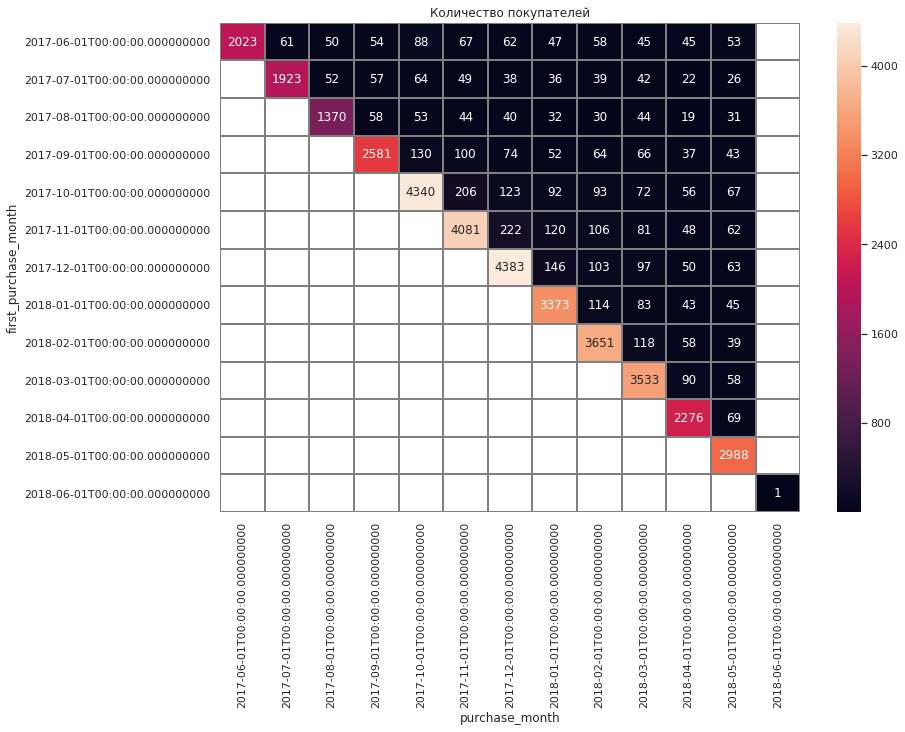

In [31]:
buyers_cohorts = orders.pivot_table(index='first_purchase_month',
    columns='purchase_month',
    values='user_id',
    aggfunc='nunique')

display(buyers_cohorts.fillna(''))

plt.figure(figsize=(13, 9))
plt.title('Количество покупателей')
sns.heatmap(buyers_cohorts, annot=True, fmt='.0f', linewidths=1, linecolor='gray')
plt.show()

после первого месяца число покупателей значительно снижается во всех когортах, это говорит о том, что окупаемость сервиса зависит не от постоянных покупателей, а во многом от постоянного привлечения новых, ранее незарегестрированных пользователей. Отобразим динамику величины покупок за весь период по когортам:

In [32]:
display(orders.pivot_table(index='first_purchase_month',
    columns='purchase_month',
    values='revenue',
    aggfunc='sum').fillna(''))

purchase_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01
first_purchase_month,,,,,,,,,,,,,
2017-06-01,9557.49,981.82,885.34,1931.3,2068.58,1487.92,1922.74,1176.56,1119.15,1225.51,1155.66,519.62,
2017-07-01,,11557.6,644.61,1199.05,690.31,339.97,300.08,231.16,272.72,310.05,282.96,299.36,
2017-08-01,,,7228.83,646.63,628.12,536.05,676.85,388.45,288.61,554.86,400.33,257.53,
2017-09-01,,,,14568.5,2884.49,1344.52,10261.5,1033.84,1670.08,1810.85,627.57,474.92,
2017-10-01,,,,,21716.2,2325.21,830.65,682.01,657.77,522.37,368.1,501.14,
2017-11-01,,,,,,21036.3,1629.27,814.39,1326.13,604.04,219.88,469.02,
2017-12-01,,,,,,,20767.5,1141.22,4054.7,4669.1,1371.57,1481.66,
2018-01-01,,,,,,,,13949.5,994.22,1026.34,481.59,211.48,
2018-02-01,,,,,,,,,15177.2,1015.98,286.66,270.7,


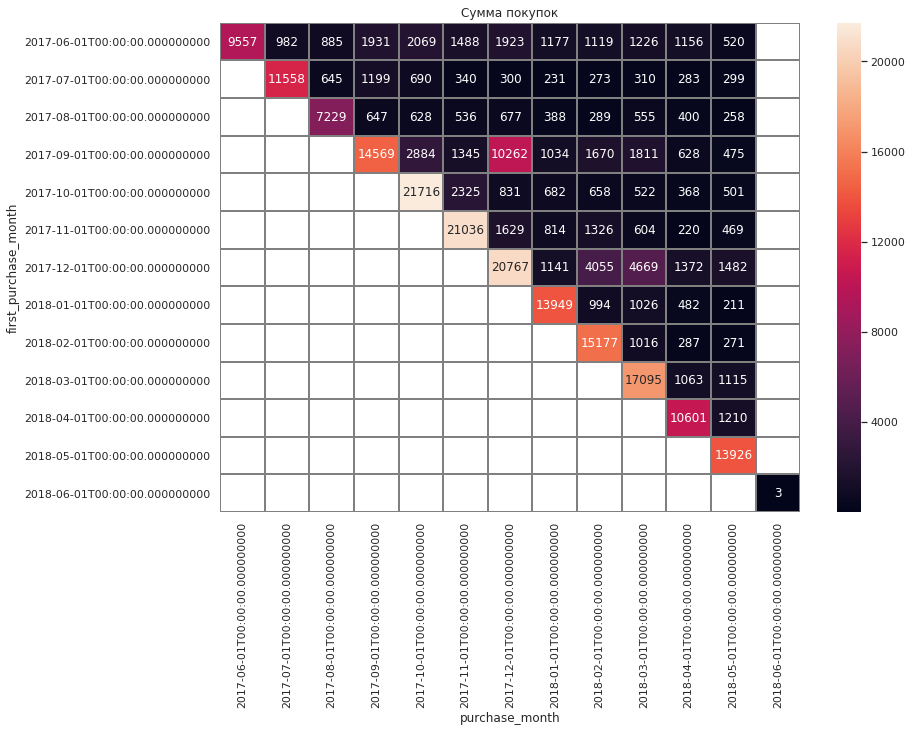

In [33]:
plt.figure(figsize=(13, 9))
plt.title('Cумма покупок')
sns.heatmap(orders.pivot_table(index='first_purchase_month',
    columns='purchase_month',
    values='revenue',
    aggfunc='sum'), annot=True, fmt='.0f', linewidths=1, linecolor='gray')
plt.show()

Видно, что после первого месяца сумма покупок значительно сокращается, за исключением когорты покупателей, совершивших первую покупку в сентябре 2017: в январе 2018 сумма покупок этой кагорты сопоставима с первым месяцем. Найдем средний чек покупателей

In [34]:
# сгруппируем данные по когорте и месяцу совершения заказа 
orders_grouped_by_cohorts = orders.groupby(['first_purchase_month','purchase_month']).agg({'revenue':'sum','user_id':'nunique'})
display(orders_grouped_by_cohorts.head(10)) 

revenue  user_id
first_purchase_month purchase_month                  
2017-06-01           2017-06-01      9557.49     2023
                     2017-07-01       981.82       61
                     2017-08-01       885.34       50
                     2017-09-01      1931.30       54
                     2017-10-01      2068.58       88
                     2017-11-01      1487.92       67
                     2017-12-01      1922.74       62
                     2018-01-01      1176.56       47
                     2018-02-01      1119.15       58
                     2018-03-01      1225.51       45

In [35]:
# найдём средний чек покупателя revenue_per_user — разделим показатель revenue на user_id:
orders_grouped_by_cohorts['revenue_per_user'] = orders_grouped_by_cohorts['revenue'] / orders_grouped_by_cohorts['user_id']

Построим сводную таблицу изменения среднего чека в когортах по месяцу совершения покупки и оценим, как изменяется средний чек с течением времени:

In [36]:
orders_grouped_by_cohorts.pivot_table(index='first_purchase_month',columns='purchase_month',values='revenue_per_user',aggfunc='mean').fillna('')

purchase_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01
first_purchase_month,,,,,,,,,,,,,
2017-06-01,4.72441,16.0954,17.7068,35.7648,23.5066,22.2078,31.0119,25.0332,19.2957,27.2336,25.6813,9.80415,
2017-07-01,,6.01022,12.3963,21.036,10.7861,6.93816,7.89684,6.42111,6.99282,7.38214,12.8618,11.5138,
2017-08-01,,,5.27652,11.1488,11.8513,12.183,16.9212,12.1391,9.62033,12.6105,21.07,8.30742,
2017-09-01,,,,5.64453,22.1884,13.4452,138.669,19.8815,26.095,27.4371,16.9614,11.0447,
2017-10-01,,,,,5.00373,11.2874,6.75325,7.41315,7.0728,7.25514,6.57321,7.4797,
2017-11-01,,,,,,5.15468,7.33905,6.78658,12.5107,7.45728,4.58083,7.56484,
2017-12-01,,,,,,,4.73819,7.81658,39.366,48.1351,27.4314,23.5184,
2018-01-01,,,,,,,,4.13564,8.72123,12.3655,11.1998,4.69956,
2018-02-01,,,,,,,,,4.15699,8.61,4.94241,6.94103,


с момента первого заказа сумма среднего чека возрастает во всех когортах, в январе 2018 кагорте сентября 2017 года средний чек увеличился больше чем в 10 раз по сравнению с первым месяцем. можно также оценить, как изменяется средний чек в зависимости от времени, прошедшего с момента первой покупки

Найдём lifetime когорты

In [37]:
orders_grouped_by_cohorts = orders_grouped_by_cohorts.reset_index()
orders_grouped_by_cohorts['cohort_lifetime'] = orders_grouped_by_cohorts['purchase_month'] - orders_grouped_by_cohorts['first_purchase_month']
display(orders_grouped_by_cohorts['cohort_lifetime'].head())

0     0 days
1    30 days
2    61 days
3    92 days
4   122 days
Name: cohort_lifetime, dtype: timedelta64[ns]

In [38]:
orders_grouped_by_cohorts['cohort_lifetime'] = orders_grouped_by_cohorts['cohort_lifetime'] / np.timedelta64(1,'M')
print(orders_grouped_by_cohorts['cohort_lifetime'].head()) 

0    0.000000
1    0.985647
2    2.004148
3    3.022649
4    4.008296
Name: cohort_lifetime, dtype: float64


In [39]:
orders_grouped_by_cohorts['cohort_lifetime'] = orders_grouped_by_cohorts['cohort_lifetime'].round().astype('int')
print(orders_grouped_by_cohorts[['first_purchase_month','purchase_month','cohort_lifetime']].head())
print(orders_grouped_by_cohorts[['first_purchase_month','purchase_month','cohort_lifetime']].tail()) 

  first_purchase_month purchase_month  cohort_lifetime
0           2017-06-01     2017-06-01                0
1           2017-06-01     2017-07-01                1
2           2017-06-01     2017-08-01                2
3           2017-06-01     2017-09-01                3
4           2017-06-01     2017-10-01                4
   first_purchase_month purchase_month  cohort_lifetime
74           2018-03-01     2018-05-01                2
75           2018-04-01     2018-04-01                0
76           2018-04-01     2018-05-01                1
77           2018-05-01     2018-05-01                0
78           2018-06-01     2018-06-01                0


In [40]:
orders_grouped_by_cohorts['first_purchase_month'].dt.strftime('%d.%m.%Y')

0     01.06.2017
1     01.06.2017
2     01.06.2017
3     01.06.2017
4     01.06.2017
         ...    
74    01.03.2018
75    01.04.2018
76    01.04.2018
77    01.05.2018
78    01.06.2018
Name: first_purchase_month, Length: 79, dtype: object

In [41]:
orders_grouped_by_cohorts['first_purchase_month'] = orders_grouped_by_cohorts['first_purchase_month'].dt.strftime('%Y-%m')

In [42]:
revenue_per_user_pivot = orders_grouped_by_cohorts.pivot_table(index='first_purchase_month',columns='cohort_lifetime',values='revenue_per_user',aggfunc='mean')

#среднее по продолжительности жизни среди всех когорт к данной сводной таблице
revenue_per_user_pivot.loc['mean'] = revenue_per_user_pivot.mean()
display(revenue_per_user_pivot.fillna(''))

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_purchase_month,,,,,,,,,,,,
2017-06,4.724414,16.0954,17.7068,35.7648,23.5066,22.2078,31.0119,25.0332,19.2957,27.2336,25.6813,9.80415
2017-07,6.010218,12.3963,21.036,10.7861,6.93816,7.89684,6.42111,6.99282,7.38214,12.8618,11.5138,
2017-08,5.276518,11.1488,11.8513,12.183,16.9212,12.1391,9.62033,12.6105,21.07,8.30742,,
2017-09,5.644529,22.1884,13.4452,138.669,19.8815,26.095,27.4371,16.9614,11.0447,,,
2017-10,5.003733,11.2874,6.75325,7.41315,7.0728,7.25514,6.57321,7.4797,,,,
2017-11,5.154683,7.33905,6.78658,12.5107,7.45728,4.58083,7.56484,,,,,
2017-12,4.738191,7.81658,39.366,48.1351,27.4314,23.5184,,,,,,
2018-01,4.135636,8.72123,12.3655,11.1998,4.69956,,,,,,,
2018-02,4.156987,8.61,4.94241,6.94103,,,,,,,,


построим тепловую карту средних чеков

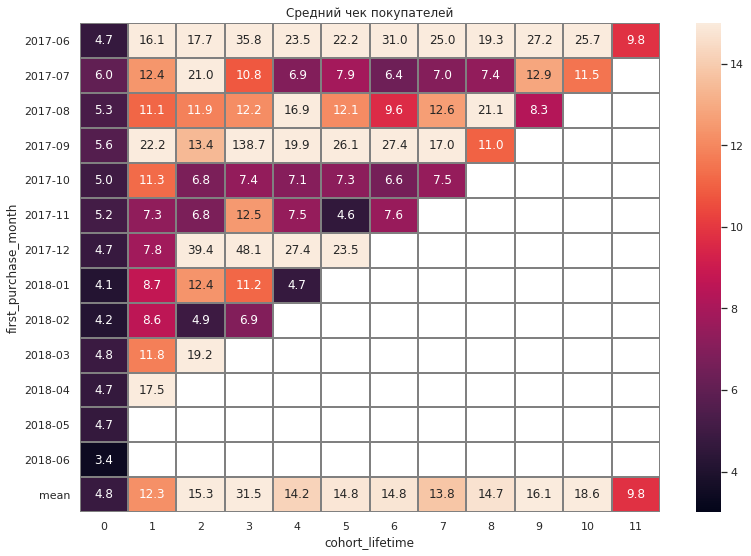

In [43]:
plt.figure(figsize=(13, 9))
plt.title('Средний чек покупателей')
sns.heatmap(revenue_per_user_pivot, annot=True, fmt='.1f', linewidths=1, linecolor='gray', vmin=3, vmax =15)
plt.show()

на карте видно, что средний чек покупателей возрастает после первого месяца. особенно это видно  кагорте сентября, где на 4 месяц жизни кагорты средний чек увеличивается в несколько раз, но возможно это связанно с каким-то локальной особенностью (например компания купила билеты всем сотрудникам на одно мероприятие)

Посчитаем LTV.</p> 

In [44]:
# найдем количество новых покупателей ежемесячно
cohort_sizes = orders.groupby('first_purchase_month').agg({'user_id': 'nunique'}).reset_index()
#first_order_month = pd.merge(orders, first_orders, on='user_id')
cohorts = orders.groupby(['first_purchase_month', 'purchase_month']).agg({'revenue': 'sum'}).reset_index()
report = pd.merge(cohort_sizes, cohorts, on='first_purchase_month')
report['age'] = (report['purchase_month'] - report['first_purchase_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')
report['ltv'] = report['revenue'] / report['user_id']
result = report.pivot_table(
        index='first_purchase_month', 
        columns='age', 
        values='ltv', 
        aggfunc='mean')
result.cumsum(axis=1).round(2).fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_purchase_month,,,,,,,,,,,,
2017-06-01,4.72,5.21,5.65,6.6,7.62,8.36,9.31,9.89,10.45,11.05,11.62,11.88
2017-07-01,6.01,6.35,6.97,7.33,7.5,7.66,7.78,7.92,8.08,8.23,8.39,
2017-08-01,5.28,5.75,6.21,6.6,7.09,7.38,7.59,7.99,8.28,8.47,,
2017-09-01,5.64,6.76,7.28,11.26,11.66,12.31,13.01,13.25,13.44,,,
2017-10-01,5.00,5.54,5.73,5.89,6.04,6.16,6.24,6.36,,,,
2017-11-01,5.15,5.55,5.75,6.08,6.23,6.28,6.4,,,,,
2017-12-01,4.74,5,5.92,6.99,7.3,7.64,,,,,,
2018-01-01,4.14,4.43,4.73,4.88,4.94,,,,,,,
2018-02-01,4.16,4.44,4.51,4.59,,,,,,,,


отобразим LTV на тепловой карте

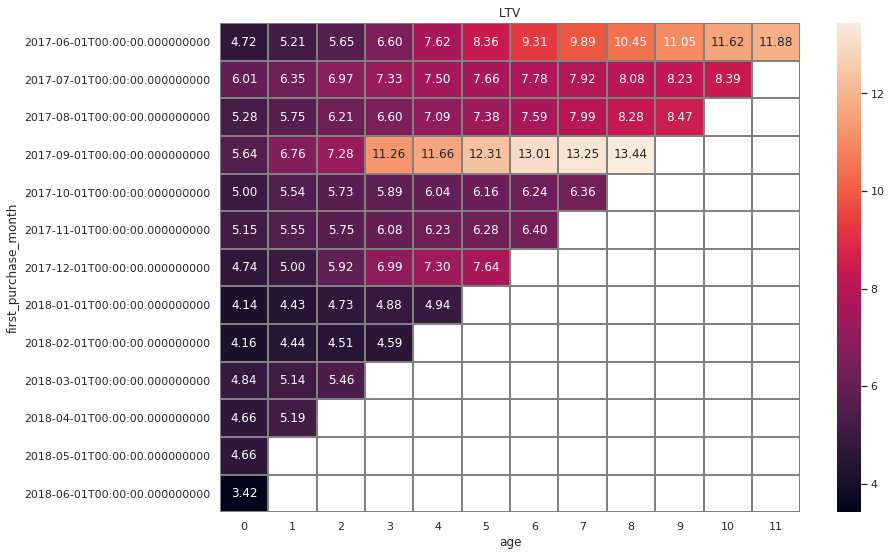

In [45]:
plt.figure(figsize=(13, 9))
plt.title('LTV')
sns.heatmap(result.cumsum(axis=1).round(2), annot=True, fmt='.2f', linewidths=1, linecolor='gray')
plt.show()

#### <a id = 'Sect2.3'></a> Шаг 2.3 Маркетинг

Проанализируем затраты на привлечение пользователей:

- Сколько денег потратили? Всего / на каждый источник / по времени
- Сколько стоило привлечение одного покупателя из каждого источника?
- На сколько окупились расходы? (ROI)

In [46]:
#cчитаем общие траты по всем источникам за весь период
total_cost = costs['costs'].sum()
print("всего на привлечение покупателей потратили", total_cost)

#считаем траты от каждого источника в отдельности и долю в затратах
costs_per_source = costs.pivot_table(index = 'source_id',values='costs', aggfunc = 'sum')
costs_per_source['portion'] = costs_per_source['costs']/total_cost
display(costs_per_source.sort_values(by ='costs', ascending = False))

всего на привлечение покупателей потратили 329131.62


,costs,portion
source_id,,
3,141321.63,0.429377
4,61073.60,0.185560
5,51757.10,0.157254
2,42806.04,0.130058
1,20833.27,0.063298
10,5822.49,0.017690
9,5517.49,0.016764


на финансирование 3-его источника потребовало 43% бюджета на маркетинг, на суммарное финансирование 4, 5 и 2  - 47%, на 1 источник около 6%, на 9 и 10  в сумме около 3%. Посмотрим на распределение трат по месяцам

In [47]:
# добавляем колонку с месяцем траты
costs['cost_month'] = costs['date'].astype('datetime64[M]')

In [48]:
 #создаем таблицу с тратами по всем источникам по месяцам
display(costs.pivot_table(index = 'cost_month', columns = 'source_id', values = 'costs', aggfunc = 'sum'))

source_id,1,2,3,4,5,9,10
cost_month,,,,,,,
2017-06-01,1125.61,2427.38,7731.65,3514.80,2616.12,285.22,314.22
2017-07-01,1072.88,2333.11,7674.37,3529.73,2998.14,302.54,329.82
2017-08-01,951.81,1811.05,6143.54,3217.36,2185.28,248.93,232.57
2017-09-01,1502.01,2985.66,9963.55,5192.26,3849.14,415.62,460.67
2017-10-01,2315.75,4845.00,15737.24,6420.84,5767.40,609.41,627.24
2017-11-01,2445.16,5247.68,17025.34,5388.82,6325.34,683.18,792.36
2017-12-01,2341.20,4897.80,16219.52,7680.47,5872.52,657.98,645.86
2018-01-01,2186.18,4157.74,14808.78,5832.79,5371.52,547.16,614.35
2018-02-01,2204.48,4474.34,14228.56,5711.96,5071.31,551.50,480.88


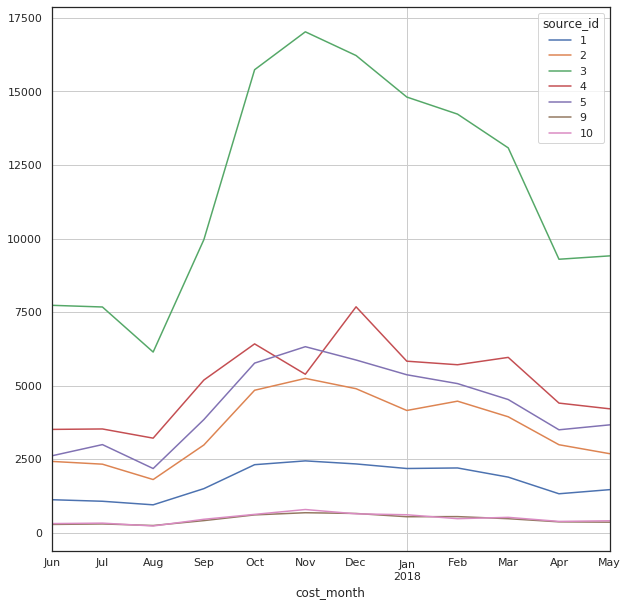

In [49]:
 #строим графики с тратами по всем источникам по месяцам
df = costs.pivot_table(index = 'cost_month', columns = 'source_id', values = 'costs', aggfunc = 'sum')
df.plot(figsize=(10,10), grid = True)
plt.show()

траты существенно возрастают с августа до середины зимы и понижаются к марту-апрелю 2018, это особенно видно на графике 3его источника, который очень выделяется из общей картины. Определим эффективность источников и окупаемость затрат

Проанализируем во сколько обходится новый клиент компании.

In [50]:
#добавим в таблицу с посещениями пользователей месяцы в которых была произведена первая покупка 
visits['first_purchase_month'] = visits['first_purchase_date'].astype('datetime64[M]')

In [51]:
# выделяем из таблицы с визитами колонки с ID пользователя, ID источника, и сессиями совершенной пользователем, и первым месяцем визита   
users = visits[['user_id', 'source_id','start_ts','first_visit_month']]

#находим первую сессию для каждого пользователя
first_visit = visits.groupby('user_id', as_index = False)['start_ts'].min()
first_visit.columns = ['user_id', 'first_visit_time']

#добавляем колонку с первой сессией в изначальную таблицу по пользователям
users = users.merge(first_visit, on = 'user_id')

# фильтруем таблицу с пользователями по первой сессии 
# (чтобы избавится от всех сессий кроме первой, source_id которой 
# соответствуют источнику из которого пришел пользователь )
users = users[users['start_ts'] == users['first_visit_time']]

#объединяем с таблицей покупок по user_id
users = users.merge(orders.groupby('user_id', as_index = False)['revenue'].sum(), on = 'user_id', how = 'left')
users = users.dropna().reset_index(drop = True)

In [52]:
display(users.head())

,user_id,source_id,start_ts,first_visit_month,first_visit_time,revenue
0,16174680259334210214,4,2018-03-09 20:05:00,2018-03-01,2018-03-09 20:05:00,2.33
1,16007536194108375387,5,2017-09-03 21:35:00,2017-09-01,2017-09-03 21:35:00,5.50
2,8056418121947262981,2,2017-06-04 14:17:00,2017-06-01,2017-06-04 14:17:00,466.57
3,18188358787673499603,3,2018-02-10 12:17:00,2018-02-01,2018-02-10 12:17:00,0.79
4,2307401184189569202,4,2017-09-23 23:27:00,2017-09-01,2017-09-23 23:27:00,3.67


In [53]:
# группируем пользователей по источникам, первым посещениям, считаем число уникальных пользователей и выручку
sources = users.groupby(['source_id', 'first_visit_month'], as_index = False).agg({'user_id':'count', 'revenue':'sum'})
sources.columns = ['source_id', 'cost_month', 'users','revenue']

# объединяем с таблицей затрат по номеру источника и месяцу 
sources = sources.merge(costs.groupby(['source_id', 'cost_month'], as_index = False)['costs'].sum(), on = ['source_id', 'cost_month'])

# считаем стоимость привлечения клиента по количеству уникальных пользователей в когорте
sources['cac'] = sources['costs'] / sources['users']


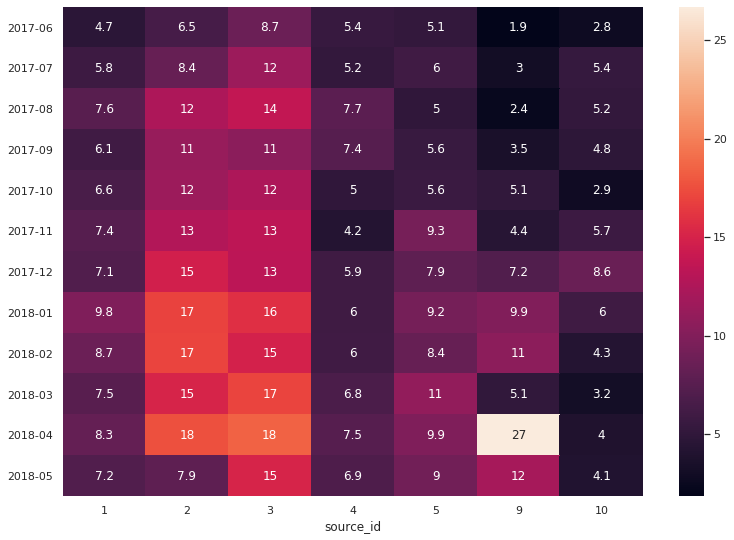

In [54]:
plt.figure(figsize=(13, 9))
sources_pivot = sources.pivot_table(index='cost_month', columns='source_id', values='cac', aggfunc = 'sum')
sources_pivot.index = sources_pivot.index.strftime('%Y-%m')
ax = sns.heatmap(sources_pivot, annot = True)

найдем общую выручку, и отношение выручки от покупателей из разных источников ко всей сумме

In [55]:
sources_abs = users.groupby('source_id').agg({'user_id':'count', 'revenue':'sum'})
revenue_total = sources_abs['revenue'].sum()
sources_abs['portion'] = sources_abs['revenue'] / revenue_total
print(revenue_total)
display(sources_abs)

252057.2000000053


,user_id,revenue,portion
source_id,,,
1,2899,31090.55,0.123347
2,3506,46923.61,0.186163
3,10473,54511.24,0.216265
4,10296,56696.83,0.224936
5,6931,52624.02,0.208778
7,1,1.22,0.000005
9,1088,5759.40,0.022850
10,1329,4450.33,0.017656


источники 2 и 3 выделяются на фоне остальных по стоимости привлечения клиентов. несмотря на то, что 2 источник обходится по содержанию не выше чем 5, он привлекает в 2 раза меньше покупателей, поэтому стоимость привлечения клиента выше

источники 1, 2, 3, 4 и 5 привлекают основное количество покупателей, которые совершают примерно сопоставимую выручку в отношении к общей сумме за весь период

 расчет накопительных  LTV и ROMI в разрезе источников 

In [56]:
# определяем источник пользователя
sources = visits.sort_values(by = ['user_id', 'start_ts']).groupby('user_id').agg({'source_id': 'first'})
# соединяем первые покупки и источники 
payers = orders.groupby('user_id').agg({'buy_ts': 'min'}).merge(sources, on = 'user_id').reset_index()
payers = payers.rename(columns = {'buy_ts': 'first_buy'})
# считаем ltv
ltv = payers.merge(orders, on = 'user_id')
ltv['lifetime'] = ((ltv['buy_ts'] - ltv['first_buy']) / np.timedelta64(1,'M')).round().astype(int)
orders_lifetime = ltv.pivot_table(index = 'source_id', columns = 'lifetime', values = 'revenue', aggfunc = 'count').fillna(0)
buyers_lifetime = ltv.pivot_table(index = 'source_id', columns = 'lifetime', values = 'user_id', aggfunc = 'nunique').fillna(0)
ltv = ltv.pivot_table(index = 'source_id', columns = 'lifetime', values = 'revenue', aggfunc = 'sum').fillna(0)
ltv = ltv.cumsum(axis = 1)

In [57]:
# добавляем размеры когорт и делим на них
cohort_sizes = payers.groupby('source_id').agg({'user_id': 'nunique'}).rename(columns = {'user_id': 'cohort_size'})
ltv = ltv.merge(cohort_sizes, on = 'source_id')
ltv = ltv.div(ltv['cohort_size'], axis = 0).drop(columns = 'cohort_size')
display(ltv)

# считаем САС
cac = costs.groupby('source_id').agg({'costs': 'sum'}).reset_index().merge(cohort_sizes.reset_index(), left_on = 'source_id', right_on='source_id')
cac['cac'] = cac['costs'] / cac['cohort_size']
cac = cac.set_index('source_id')
display(cac)

# считаем ROMI
romi = ltv.merge(cac[['cac']], on = 'source_id')
romi = romi.div(romi['cac'], axis = 0).drop(columns = 'cac')
display(romi)

,0,1,2,3,4,5,6,7,8,9,10,11,12
source_id,,,,,,,,,,,,,
1,6.156185,7.150835,7.891156,8.537754,9.029303,9.251083,9.525826,9.866858,10.191256,10.450862,10.557561,10.673508,10.724577
2,6.770593,8.054740,9.717921,11.253637,11.900125,12.484390,12.721418,12.948380,13.171358,13.233560,13.346994,13.380422,13.383802
3,4.477694,4.729283,4.865748,5.008149,5.083093,5.122590,5.147003,5.173669,5.192354,5.197477,5.202699,5.203834,5.204931
4,4.584762,4.738128,4.852278,4.948617,5.068362,5.226563,5.342363,5.391025,5.410340,5.448244,5.502627,5.505380,5.506685
5,4.909883,5.114191,5.469974,6.836748,7.072747,7.246335,7.365203,7.454998,7.515129,7.576270,7.582746,7.592303,7.592558
7,1.220000,1.220000,1.220000,1.220000,1.220000,1.220000,1.220000,1.220000,1.220000,1.220000,1.220000,1.220000,1.220000
9,3.880901,4.167390,4.408024,4.678888,4.788189,4.935588,5.059127,5.126608,5.244430,5.284972,5.293566,5.293566,5.293566
10,3.164131,3.227434,3.254695,3.302558,3.316576,3.319217,3.332724,3.343348,3.346102,3.348631,3.348631,3.348631,3.348631


,costs,cohort_size,cac
source_id,,,
1,20833.27,2899,7.186364
2,42806.04,3506,12.209367
3,141321.63,10473,13.493901
4,61073.60,10296,5.931779
5,51757.10,6931,7.467479
9,5517.49,1088,5.071222
10,5822.49,1329,4.381106


,0,1,2,3,4,5,6,7,8,9,10,11,12
source_id,,,,,,,,,,,,,
1,0.856648,0.995056,1.098073,1.188049,1.256449,1.287311,1.325542,1.372997,1.418138,1.454263,1.469110,1.485245,1.492351
2,0.554541,0.659718,0.795940,0.921722,0.974672,1.022526,1.041939,1.060528,1.078791,1.083886,1.093177,1.095915,1.096191
3,0.331831,0.350476,0.360589,0.371142,0.376696,0.379623,0.381432,0.383408,0.384793,0.385172,0.385559,0.385643,0.385725
4,0.772915,0.798770,0.818014,0.834255,0.854442,0.881112,0.900634,0.908838,0.912094,0.918484,0.927652,0.928116,0.928336
5,0.657502,0.684862,0.732506,0.915536,0.947140,0.970386,0.986304,0.998329,1.006381,1.014569,1.015436,1.016716,1.016750
9,0.765279,0.821772,0.869223,0.922635,0.944188,0.973254,0.997615,1.010922,1.034155,1.042150,1.043844,1.043844,1.043844
10,0.722222,0.736671,0.742894,0.753818,0.757018,0.757621,0.760704,0.763129,0.763757,0.764335,0.764335,0.764335,0.764335


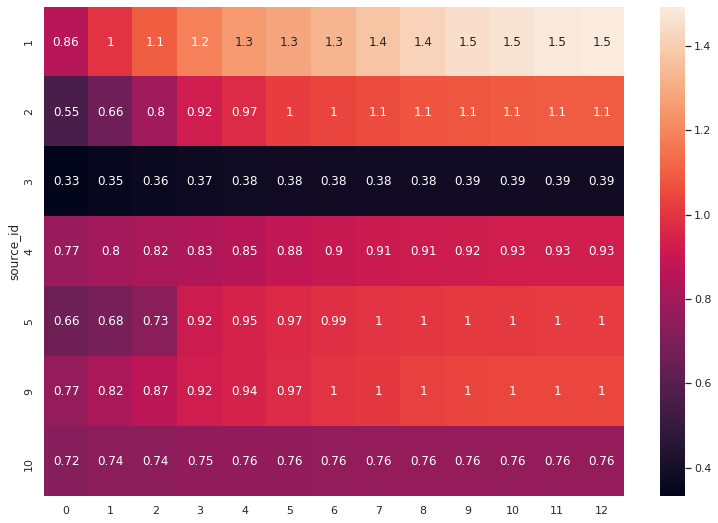

In [58]:
plt.figure(figsize=(13, 9))
ax = sns.heatmap(romi, annot = True)

### <a id = 'Sect3'></a> Шаг 3. Вывод

<b>Продукт: </b> 
- медиана визитов за день: <br />
desktop: 709 <br />
touch : 278
- медиана визитов за неделю: <br />
desktop: 4892 <br />
touch: 1874 <br />
- медиана визитов за месяц: <br />
desktop: 19226 <br />
touch: 7749 <br />

в летние месяцы число пользователей сокращается, люди предпочитают организовывать свой досуг на воздухе или уезжают, также это может быть связано с тем, что в театрах заканчивается сезон и летом проводится меньше спектаклей, постановок, показов. Осенью активность возрастает, пик приходится на ноябрь 2017.

- c desktop-a заходят гораздо чаще, чем с мобильных устройств (~ 72% / 28%)

- среднее количество уникальных пользователей : <br />
в месяц, MAU : 21441 (колеблется от 12 тыс на лето 2017 до 30 тыс осенью 2017) <br />
в неделю, WAU : 5825 <br />
в день, DAU : 906 <br />

- количество сессий приходящихся на каждого уникального пользователя по месяцам колеблется от 1.25 -1.35 сессий в день
- медиана продолжительности сессии с ПК и мобильных устройств 5 минут, наиболее часто встречающаяся продолжительность сессии 1 минута.

- Статистика продолжительности сессий:<br />

In [59]:
print('статистика продолжительности сессий (desktop):', visits.query('device == "desktop"')['sess_duration_min'].describe())
print('статистика продолжительности сессий (touch):',visits.query('device == "touch"')['sess_duration_min'].describe())

статистика продолжительности сессий (desktop): count    78158.000000
mean        16.656644
std         23.106831
min          0.000000
25%          3.000000
50%          9.000000
75%         22.000000
max        596.000000
Name: sess_duration_min, dtype: float64
статистика продолжительности сессий (touch): count    19236.000000
mean        12.462466
std         18.862018
min          0.000000
25%          2.000000
50%          6.000000
75%         16.000000
max        514.000000
Name: sess_duration_min, dtype: float64


- в последующие месяцы после первого визита возращается от 2% до 9% пользователей

<b>Продажи: </b> 

статистика времени, прошедшего между первым посещением и первой покупкой <br />
mean     33 days <br />
std      63 days <br />
25%      0  days <br />
50%      1  days <br />
75%      37 days <br />

25% пользователей сделали покупку в день первого посещения, а 50% на следующий день

- за период пользователи каждой кагорты делают 2000 -5000 покупок, больше осенью 2017 <br />
- средний чек покупателей очень отличается по месяцам и когортам (от 5 до 30-40, в отдельном случае до 139)
  средний чек покупателей возрастает после первого месяца. особенно это видно в когорте сентября, где на 4 месяц     жизни когорты средний чек увеличивается в несколько раз, но возможно это связанно с каким-то локальной             особенностью (например компания купила билеты всем сотрудникам на одно мероприятие)
- клиент приносит в среднем со всех своих покупок (LTV) от 4 до 13 


<b>Маркетинг</b> 

- всего на привлечение покупателей потратили 329131.62
финансирование 3-его источника потребовало 43% бюджета на маркетинг, на суммарное финансирование 4, 5 и 2 - 47%, на 1 источник около 6%, на 9 и 10 в сумме около 3%. 
траты существенно возрастают с августа до середины зимы и понижаются к марту-апрелю 2018, это особенно видно на графике 3его источника, который очень выделяется из общей картины.

Распределение стоимости привлечение одного покупателя из каждого источника:

In [60]:
display(cac)

,costs,cohort_size,cac
source_id,,,
1,20833.27,2899,7.186364
2,42806.04,3506,12.209367
3,141321.63,10473,13.493901
4,61073.60,10296,5.931779
5,51757.10,6931,7.467479
9,5517.49,1088,5.071222
10,5822.49,1329,4.381106


Окупаемость источников:
источник #3 на который тратится почти половина бюджета на маркетинг показывает самую низкую окупаемость по сравнению с остальными источниками на последней тепловой карте.
покупатели из 1, 4 и 5 источников делают больше 50% выручки, привлекают сопоставимое количество покупателей как и дорогостоящие 2 и 3 источники, при этом затраты на их финансирование значительно ниже.

<b>Рекомендации</b>

- необходимо оптимизировать затраты на 3 источник в связи с высокими тратами и низкой покупательской активностью
- стоит проверить работу мобильной версии так как сессий произведенных с ПК более чем в 2 раза, что может говорить о том, что пользователям по какой-то причине менее удобно с ней работать
- стоит разработать тактики, для того, чтобы покупатели больше возвращались после совершения первой покупки и активнее привлекались в летние месяцы